## SNP typing and lineage naming from WGS using reference population

References:

* https://www.frontiersin.org/articles/10.3389/fmicb.2020.00843/full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3502966/

Selection of reference population:

* Global
* European
* UK/Ireland
* All Ireland (republic + NI)

required: 

* We need to be able to add new samples to the existing **reference** population phylogeny without having to re-analyse everything together.
* We need to have a sufficiently sampled reference matrix that it will cover most potential new inputs. Otherwise they will be considered outgroups.

Method: 

* add one or more samples to an existing population snp matrix - concatenate two sets of snps into one matrix by keeping only the polymorphic sites in the reference matrix. sites not present in the unknown samples are replaced with Ns
* generate a new phylogeny from the combined snp matrix or just cluster them
* find nearest neighbours and identify the unknown isolates with a known clade

In [449]:
import sys,os
import numpy as np
import pandas as pd
import pylab as plt
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO,AlignIO
from Bio import Phylo
import seaborn as sns
import toytree
from snipgenie import app, trees, tools

In [ ]:
def matrix_to_records(df):
    """Write nuc snp matrix to seqrecords"""
    
    recs=[]
    for i,r in df.iterrows():
        #print(i,r.values)
        seq = ''.join(r.values)
        seqrec = SeqRecord(Seq(seq),id=i)
        recs.append(seqrec)
        print (len(seqrec))
    return

def snps_to_fasta(snpmat, outfile):
    """Write snp matrix to fasta file"""
    
    snpmat = snpmat.fillna('N')
    recs = []
    for col in snpmat.columns[1:]:
        seq = ''.join(snpmat[col])        
        seqrec = SeqRecord(Seq(seq),id=col)
        recs.append(seqrec)
    SeqIO.write(recs, outfile, 'fasta')
    return    

def tree_from_snps(snpmat):
    snps_to_fasta(snpmat, 'snps.fa') 
    treefile = trees.run_fasttree('snps.fa')
    tre = toytree.tree(treefile)
    mystyle = { "layout": 'r','node_sizes':1,'tip_labels_align':False}
    tre.ladderize().draw(**mystyle,width=700);
    return tre

snps_to_fasta(snpmat, 'snps.fa')
tree_from_snps(snpmat)

## get snp matrices for ref population

In [436]:
nucmat = pd.read_csv('../snipgenie/data/nuc_snps_ireland.txt',sep=' ')
#
csqmat = pd.read_csv('../snipgenie/data/snps_ireland.csv',index_col=[0,1,2,3,4])

In [438]:
X=snpmat.set_index('pos').sample(250).sort_index()
mapping = {"A": 1, "T": 2, "C": 3, "G": 4}
X=X.replace(mapping)
#sns.clustermap(X,row_cluster=False,yticklabels=False,figsize=(15,10))

In [ ]:
X=csqmat
print (X.iloc[:2,:3])
sns.clustermap(X,xticklabels=False,figsize=(15,10),cmap='gray_r',cbar_pos=None)

## combine sub sample of nucleotide snps with original matrix

In [430]:
X = nucmat.set_index('pos').sort_index()
X
m1 = X.sample(50,axis=1,random_state=2)
m1 = m1[2:]
m2 = X.sample(5,axis=1,random_state=5)
m2 = m2[:-4]
print (m2)
    
tree_from_snps(m2)

        2606 19-6357 3090 2980 19-2786
pos                                   
687        T       T    C    C       C
937        A       A    G    A       A
1303       G       G    G    G       G
1456       G       G    G    G       G
1584       T       T    T    T       T
...      ...     ...  ...  ...     ...
3825991    G       G    G    G       G
3827894    T       T    T    T       T
3828728    G       G    A    A       G
3830688    G       G    G    G       G
3832251    G       G    G    G       G

[1742 rows x 5 columns]


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="700.0px" height="275.0px" viewBox="0 0 700.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t5cc01d39c6e94ec0aaa947bb81cb77ed"> 19-2786 19-6357 2980 3090

In [ ]:
new = m1.join(m2).fillna('N')
new
tree_from_snps(new)

## distance matrix for joined nuc alignment

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


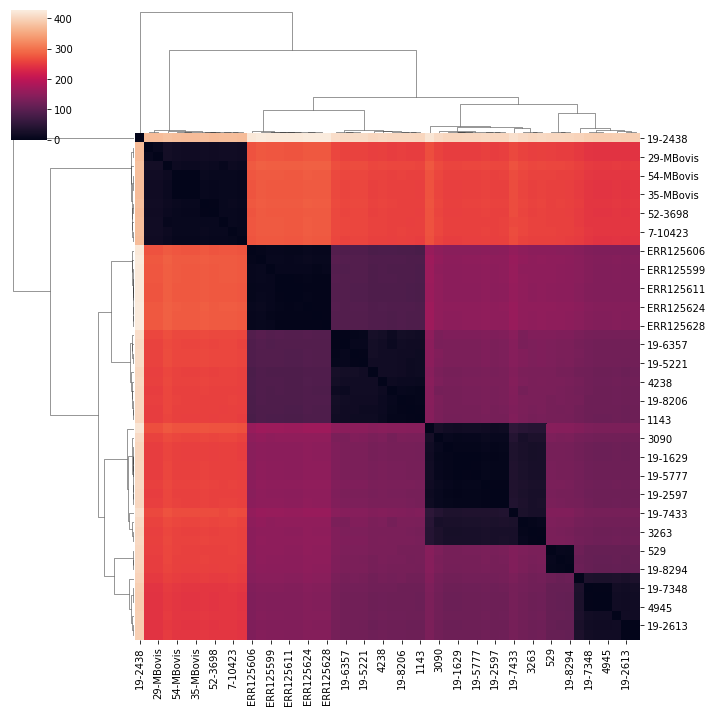

In [441]:
#print (m2)

outfasta='snps.fa'
snps_to_fasta(new, outfasta)
#SeqIO.write(snprecs, 'snps.fasta', 'fasta')
aln = AlignIO.read(outfasta, 'fasta')
#print (aln)
snp_dist = tools.snp_dist_matrix(aln)
sns.clustermap(snp_dist,figsize=(10,10))

## find nearest isolate

In [442]:
def get_nearest_neighbours(X, name, n=3):
    """Get nearest samples in reference matrix"""
       
    r = X.loc[name].drop(name)    
    #print (r[r<d].index)
    df=r.sort_values()[:n].reset_index()
    df.columns=['name','dist']
    return df

n = get_nearest_neighbours(snp_dist, '19-2786')
n

,name,dist
0,1143,5
1,19-6317,6
2,19-8206,7


## lookup sample

In [481]:
def get_sample_details(name):
    """Lookup sample in reference matrix"""
    
    X = csqmat.reset_index()
    r = X[X.name==name]
    if len(r)==0:
        return
    return r.iloc[0]

for i,r in n.iterrows():
    x = get_sample_details(r['name'])
    print (x['name'],x.clade)

1143 Monaghan-3
19-6317 Monaghan-3
19-8206 Monaghan-3


In [484]:
def snp_typing(snpmat, refmat=None):
    """Type samples using known population"""

    if refmat == None:   
        refmat = pd.read_csv('../snipgenie/data/nuc_snps_ireland.txt',sep=' ')
    X = refmat.set_index('pos').sort_index()
    
    #join matrix
    try:
        new = refmat.join(snpmat).fillna('N')
    except ValueError:
        print ('columns overlap')
        return
    
    outfasta='snps.fa'
    snps_to_fasta(new, outfasta)
    #SeqIO.write(snprecs, 'snps.fasta', 'fasta')
    aln = AlignIO.read(outfasta, 'fasta')
    #print (aln)
    snp_dist = tools.snp_dist_matrix(aln)
    
    #get nearest isolates
    n = get_nearest_neighbours(snp_dist, '19-2786')    
    for i,r in n.iterrows():
        x = get_sample_details(r['name'])
        print (x['name'],x.clade)
    return


## test typing workflow

In [483]:
snp_typing(m2)

columns overlap
